# Laboratory #3 : Face detection and recognition

At the end of this laboratory, you would get familiarized with

*   Face detection
    *   Integral images
    *   Haar-like feature computation
    *   Adaboost 
*   Face recognition
    *   Eigen Faces
    *   PCA and LDA

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

In [1]:
# mount drive to the notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Face Detection using AdaBoost

In [2]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)
import numpy as np
from skimage import data
import os,matplotlib
from PIL import Image
from multiprocessing import Pool
from functools import partial
import time, timeit
from matplotlib import pyplot as plt
import tqdm 
from tqdm import tqdm
import cv2

### Exercise #1

*   Build a function compute_integral_image that computes the integral image of an input (2D) array. In an integral image each pixel is the sum of all pixels in the original image that are 'left and above' the pixel. See the following example:

```
Original    Integral
+--------   +------------
| 1 2 3 .   | 0  0  0  0 .
| 4 5 6 .   | 0  1  3  6 .
| . . . .   | 0  5 12 21 .
            | . . . . . .
```

*   The integral image must have an additional row and column full of zeros (first row and first column).
*   Plot the output of the integral image for the following array:

```
img_array = np.array([[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1]])
```

In [3]:
def compute_integral_image(img_arr):
    """
    Calculates the integral image based on this instance's original image data.
    :param img_arr: Image source data
    :type img_arr: numpy.ndarray
    :return Integral image for given image
    :rtype: numpy.ndarray
    """
    # an index of -1 refers to the last row/column
    # since row_sum is calculated starting from (0,0),
    # rowSum(x, -1) == 0 holds for all x
    row_sum = np.zeros(img_arr.shape)
    # we need an additional column and row
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))
    for xx in range(img_arr.shape[1]):
        for yy in range(img_arr.shape[0]):
            row_sum[yy, xx] = row_sum[yy-1, xx] + img_arr[yy, xx]
            integral_image_arr[yy+1, xx+1] = integral_image_arr[yy+1, xx-1+1] + row_sum[yy, xx]
    return integral_image_arr

In [4]:
# much faster than brute force of manual attempt 
# using this to increase performance of the learning phase 
# total time of classifier_2 & classifier_20 ~ 20 min!!
def fast_integral_image(img_arr):
  img_arr = np.float32(img_arr)
  return cv2.integral(img_arr)

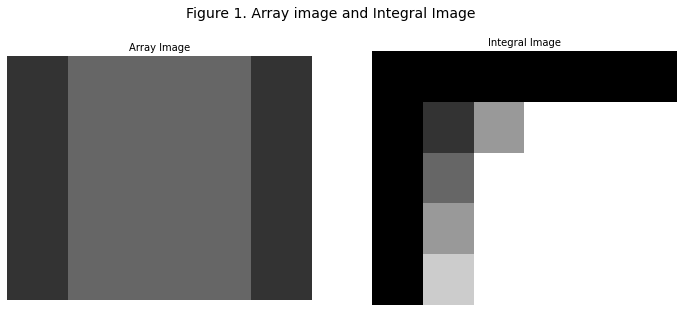

In [5]:
img_array = np.array([[1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1]])
ii_img_array = fast_integral_image(img_array)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))
ax1.imshow(img_array, cmap="gray", vmin=0, vmax= 5)
ax1.set_title('Array Image',size=10)
ax1.axis('off')
ax2.imshow(ii_img_array, cmap="gray", vmin=0, vmax= 5)
ax2.set_title('Integral Image',size=10)
ax2.axis('off')
plt.suptitle("Figure 1. Array image and Integral Image",y=0.8,size=14)
plt.show()

In [6]:
#comparisson 
%%timeit
img_array = np.array([[1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1]])
compute_integral_image(img_array)

10000 loops, best of 5: 39.4 µs per loop


In [7]:
#comparisson 
%%timeit
img_array = np.array([[1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1]])

fast_integral_image(img_array)

The slowest run took 165.25 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 8.18 µs per loop


*   Test the function using 'camera' image from the data module. Plot the original image and the integral image.

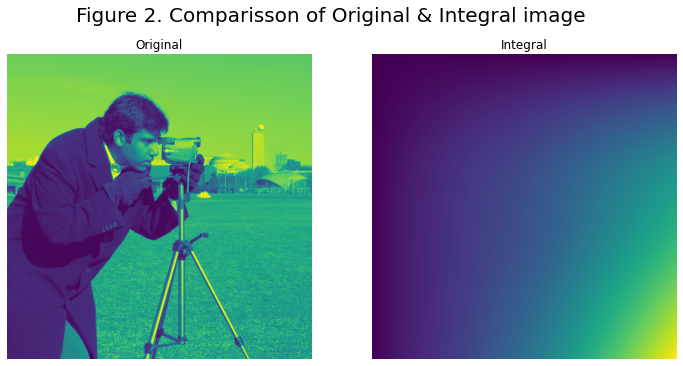

In [8]:
# solution
camera_img = np.array(data.camera())
ica_img_array = fast_integral_image(camera_img)
fg, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,8))
plt.suptitle('Figure 2. Comparisson of Original & Integral image',y=0.85,size=20)
ax1.imshow(camera_img)
ax1.axis('off')
ax1.set_title('Original',size=12)
ax2.imshow(ica_img_array)
ax2.axis('off')
ax2.set_title("Integral",size=12)
plt.show()

### Exercise #2

*   Create a function sum_region to compute the sum of the pixel intensities within a rectangle using the integral image. The rectangle will be defined using the top left (x, y) and bottom right (x, y) coordinates.

In [9]:
def sum_region(integral_img_arr, top_left, bottom_right):
    """
    Calculates the sum in the rectangle specified by the given tuples.
    :param integral_img_arr:
    :type integral_img_arr: numpy.ndarray
    :param top_left: (x, y) of the rectangle's top left corner
    :type top_left: (int, int)
    :param bottom_right: (x, y) of the rectangle's bottom right corner
    :type bottom_right: (int, int)
    :return The sum of all pixels in the given rectangle
    :rtype int
    """
    # swap tuples
    # top_left = (Y1, X1)
    top_left = (top_left[1], top_left[0])
    # bottom_right = (Y2, X2)
    bottom_right = (bottom_right[1], bottom_right[0])
    # (Y1, X1) == (Y2, X2)
    if top_left == bottom_right:
        return integral_img_arr[top_left]
    # top_right = (Y2, X1)
    top_right = (bottom_right[0], top_left[1])
    # bottom_left = (Y1, X2)
    bottom_left = (top_left[0], bottom_right[1])
    # sepparating the points
    # vA -> vB 
    vA = integral_img_arr[bottom_right]
    vB = integral_img_arr[top_right]
    # vC -> vD
    vC = integral_img_arr[bottom_left]
    vD = integral_img_arr[top_left]
    return vA - vB - vC + vD


*   Make the following tests:

In [10]:
# result you should get (12)
print(f"Test 1. (ans = 12): {sum_region(ii_img_array, [1, 1], [3, 4])}")
# result you should get (32)
print(f"Test 2. (ans = 32): {sum_region(ii_img_array, [0, 0], [-1, -1])}")

Test 1. (ans = 12): 12.0
Test 2. (ans = 32): 32.0


### Exercise #3

*   Build a function load_integral_images to read all the images inside a given folder and compute the integral image of every image

In [21]:
def load_integral_images(path):
  ii_images = []
  print(f"\t {path.split('/')[-1]}")
  for _file in tqdm(os.listdir(path)):
      if _file.endswith('.png'):
        loaded_img = np.array(Image.open(f'{path}/{_file}'),dtype=np.float64)
        try:
          loaded_img = fast_integral_image(loaded_img)
          loaded_img = loaded_img / loaded_img.max()
          ii_images.append(loaded_img)
        except:
          pass
  return ii_images

*   Use the load_integral_images function to compute the integral images of training and testing data

In [11]:
# change paths to your location
#main dir   
#root_dir = './images'
root_dir = '/content/drive/MyDrive/Notebooks/CV/LABS/p3_face_detection_and_recognition/images'
# training 
pos_train = 'train_data/faces'
neg_train = 'train_data/non_faces'
#testing 
pos_test = 'test_data/faces'
neg_test = 'test_data/non_faces'
# path to training
pos_training_path = f"{root_dir}/{pos_train}"
neg_training_path = f"{root_dir}/{neg_train}"
#path to testing
pos_testing_path = f"{root_dir}/{pos_test}"
neg_testing_path = f"{root_dir}/{neg_test}"

#and a corresponding list filename to each 
#train
pos_train_imgs_names = [pos_training_path+ '/' + x for x in os.listdir(pos_training_path)]
neg_train_imgs_names = [neg_training_path+ '/' + x for x in os.listdir(neg_training_path)]
#testing
pos_test_imgs_names = [pos_testing_path+ '/' + x for x in os.listdir(pos_testing_path)]
neg_test_imgs_names = [neg_testing_path+ '/' + x for x in os.listdir(neg_testing_path)]

In [24]:
# Made a function to remove all the *.ini files because they were bothering us
'''
import glob 
def remove_ini_files()
  pathy = '/content/drive/MyDrive/Notebooks/CV/LABS/p3_face_detection_and_recognition/images/**/*.ini'
  k = glob.glob(pathy, recursive=True)
  for u in k: 
    os.remove(u)
  print(f"All *.ini files removed from {pathy}")
'''

'\nimport glob \ndef remove_ini_files()\n  pathy = \'/content/drive/MyDrive/Notebooks/CV/LABS/p3_face_detection_and_recognition/images/**/*.ini\'\n  k = glob.glob(pathy, recursive=True)\n  for u in k: \n    os.remove(u)\n  print(f"All *.ini files removed from {pathy}")\n'

In [22]:
# training
pos_train_imgs = load_integral_images(pos_training_path)
neg_train_imgs = load_integral_images(neg_training_path)
#testing
pos_test_imgs = load_integral_images(pos_testing_path)
neg_test_imgs = load_integral_images(neg_testing_path)

	 faces


100%|██████████| 757/757 [00:01<00:00, 685.32it/s]


	 non_faces


  2%|▏         | 139/8547 [00:00<00:12, 692.93it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
100%|██████████| 8547/8547 [00:12<00:00, 695.52it/s]


	 faces


100%|██████████| 472/472 [00:00<00:00, 699.25it/s]


	 non_faces


100%|██████████| 128/128 [00:00<00:00, 650.91it/s]


*   Visualize a few original images and the corresponding integral images using matplotlib.

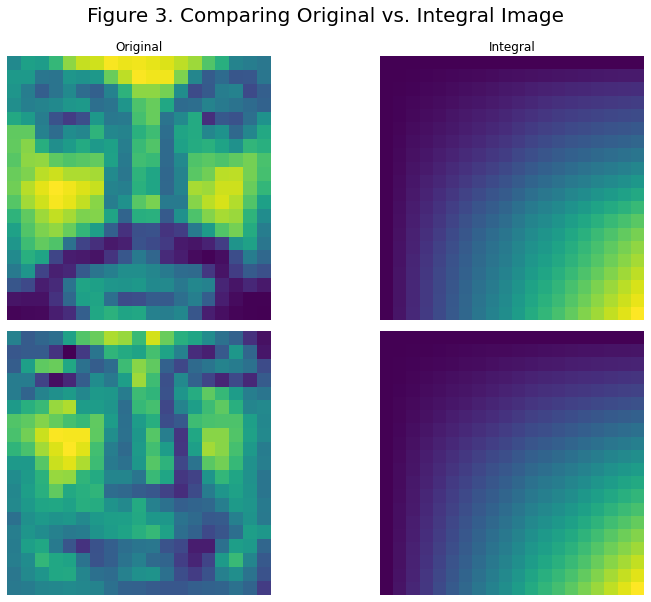

In [23]:
#solution
# we can get a sample of positive and negative faces with their integral images 
LIMIT = 2 # Change this value to have more images in the columns 
# Zipping --> Original Image name with image 
pos_sample = list(zip(pos_train_imgs_names[:LIMIT],pos_train_imgs[:LIMIT]))
neg_sample = list(zip(neg_train_imgs_names[:LIMIT],neg_train_imgs[:LIMIT]))
# we can show a 2x2 
ROWS, COLUMNS, FIGSIZE = LIMIT, 2, (12,8)
fig, axs = plt.subplots(ROWS, COLUMNS,figsize=FIGSIZE)
for idx,sample in enumerate(pos_sample):
    #original images
    axs[idx,0].imshow(plt.imread(sample[0]))
    axs[0,0].set_title(f"Original")
    axs[idx,0].axis('off')
    #Integral images
    axs[idx,1].imshow(sample[1])
    axs[0,1].set_title(f"Integral")
    axs[idx,1].axis('off')
plt.suptitle("Figure 3. Comparing Original vs. Integral Image",size=20,y=1.04)
plt.tight_layout()
plt.show()


### Exercise #4

*   Compute the Haar features of an image.
*   We provide you with HaarLikeFeature class that has build in a get_score function and a get_vote function. Your job is to complete the code of the method _create_features in the class HaarLikeFeature:

In [25]:
def enum(**enums):
    return type('Enum', (), enums)

FeatureType = enum(TWO_VERTICAL=(1, 2), TWO_HORIZONTAL=(2, 1), THREE_HORIZONTAL=(3, 1), THREE_VERTICAL=(1, 3), FOUR=(2, 2))
FeatureTypes = [FeatureType.TWO_VERTICAL, FeatureType.TWO_HORIZONTAL, FeatureType.THREE_VERTICAL, FeatureType.THREE_HORIZONTAL, FeatureType.FOUR]

In [26]:
class HaarLikeFeature(object):
    def __init__(self, feature_type, position, width, height, threshold, polarity):
        self.type = feature_type
        self.top_left = position
        self.bottom_right = (position[0] + width, position[1] + height)
        self.width = width
        self.height = height
        self.threshold = threshold
        self.polarity = polarity
        self.weight = 1
    
    def get_score(self, int_img):
        score = 0
        if self.type == FeatureType.TWO_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.TWO_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.THREE_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 3), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 3), self.top_left[1]), (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1] + self.height))
            third = sum_region(int_img, (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1]), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.THREE_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.bottom_right[0], int(self.top_left[1] + self.height / 3)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 3)), (self.bottom_right[0], int(self.top_left[1] + 2 * self.height / 3)))
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + 2 * self.height / 3)), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.FOUR:
            # top left area
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)))
            # top right area
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), (self.bottom_right[0], int(self.top_left[1] + self.height / 2)))
            # bottom left area
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), (int(self.top_left[0] + self.width / 2), self.bottom_right[1]))
            # bottom right area
            fourth = sum_region(int_img, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second - third + fourth
        return score
    
    def get_vote(self, int_img):
        score = self.get_score(int_img)
        return self.weight * (1 if score < self.polarity * self.threshold else -1)

In [27]:
def learn(positive_iis, negative_iis, num_classifiers=-1, min_feature_width=1, max_feature_width=-1, min_feature_height=1, max_feature_height=-1):
    num_pos = len(positive_iis)
    num_neg = len(negative_iis)
    num_imgs = num_pos + num_neg
    img_height, img_width = positive_iis[0].shape

    # Maximum feature width and height default to image width and height
    max_feature_height = img_height if max_feature_height == -1 else max_feature_height
    max_feature_width = img_width if max_feature_width == -1 else max_feature_width

    # Create initial weights and labels
    pos_weights = np.ones(num_pos) * 1. / (2 * num_pos)
    neg_weights = np.ones(num_neg) * 1. / (2 * num_neg)
    weights = np.hstack((pos_weights, neg_weights))
    labels = np.hstack((np.ones(num_pos), np.ones(num_neg) * -1)) 

    images = positive_iis + negative_iis
    print("Creating feature ....")
    # Create features for all sizes and locations
    features = _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height)
    num_features = len(features)
    feature_indexes = list(range(num_features))

    num_classifiers = num_features if num_classifiers == -1 else num_classifiers

    print('Calculating scores for images..')
    t0 = time.time()
    votes = np.zeros((num_imgs, num_features))
    # Use as many workers as there are CPUs
    pool = Pool(processes=None)
    for i in tqdm(range(num_imgs)):
        votes[i, :] = np.array(list(pool.map(partial(_get_feature_vote, image=images[i]), features)))

    
    print('\tTime needed for calculating scores:', time.time()-t0)
    
    # select classifiers
    classifiers = []

    t0 = time.time()
    print('Selecting classifiers..')
    for _ in tqdm(range(num_classifiers)):

        classification_errors = np.zeros(len(feature_indexes))

        # normalize weights
        weights *= 1. / np.sum(weights)

        # select best classifier based on the weighted error
        for f in range(len(feature_indexes)):
            f_idx = feature_indexes[f]
            # classifier error is the sum of image weights where the classifier
            # is right
            error = sum(map(lambda img_idx: weights[img_idx] if labels[img_idx] != votes[img_idx, f_idx] else 0, range(num_imgs)))
            classification_errors[f] = error

        # get best feature, i.e. with smallest error
        min_error_idx = np.argmin(classification_errors)
        best_error = classification_errors[min_error_idx]
        best_feature_idx = feature_indexes[min_error_idx]

        # set feature weight
        best_feature = features[best_feature_idx]
        feature_weight = 0.5 * np.log((1 - best_error) / best_error)
        best_feature.weight = feature_weight

        classifiers.append(best_feature)

        # update image weights
        weights = np.array(list(map(lambda img_idx: weights[img_idx] * np.sqrt((1-best_error)/best_error) if labels[img_idx] != votes[img_idx, best_feature_idx] else weights[img_idx] * np.sqrt(best_error/(1-best_error)), range(num_imgs))))

        # remove feature (a feature can't be selected twice)
        feature_indexes.remove(best_feature_idx)

    print('\tTime needed for Selecting Classifiers:', time.time()-t0,'\n')

    return classifiers


def _get_feature_vote(feature, image):
    return feature.get_vote(image)


def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating haar-like features..')
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                for x in range(img_width - feature_width):
                    for y in range(img_height - feature_height):
                        features.append(HaarLikeFeature(feature, (x, y), feature_width, feature_height, 0, 1))
                        features.append(HaarLikeFeature(feature, (x, y), feature_width, feature_height, 0, -1))
    print('..done. ' + str(len(features)) + ' features created.\n')
    return features

### Exercise #5

*   Use the learn method to learn a list of two classifiers with the train data. With the learn function you can build a list of classifiers that detect whether an image contains a face or not.

*   Use the following hyperparameters of the features and num_classifiers

In [28]:
num_classifiers = 2
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [29]:
# solution

#%%time 
classifiers = learn(pos_train_imgs, 
                    neg_train_imgs, 
                    num_classifiers, 
                    min_feature_width, 
                    max_feature_width, 
                    min_feature_height, 
                    max_feature_height)

Creating feature ....
Creating haar-like features..
..done. 2496 features created.

Calculating scores for images..


100%|██████████| 9304/9304 [04:41<00:00, 33.00it/s]


	Time needed for calculating scores: 282.13267064094543
Selecting classifiers..


100%|██████████| 2/2 [00:40<00:00, 20.11s/it]

	Time needed for Selecting Classifiers: 40.22575354576111 



### Exercise #6

*   Make a function for voting with different classifiers
*   Build two functions ensemble_vote and ensemble_vote_all.
*   **ensemble_vote(int_img, classifiers)** has to return a 1 if the majority of the votes of the classifiers is positive and a zero otherwise
*   **ensemble_vote_all(int_imgs, classifiers)** has to loop over the list int_imgs and compute the ensemble_vote for each image in the list. It has to return a list containing all the votes for all the images in int_imgs.


In [30]:
# solution
def ensemble_vote(int_img, classifiers):
    return 1 if sum([classifier.get_vote(int_img) for classifier in classifiers]) >= 0 else 0


def ensemble_vote_all(int_imgs, classifiers):
    return [ ensemble_vote(img, classifiers) for img in int_imgs ]

*   Use the functions to compute the train and test acurracies for faces and non faces.
*   Print the results in the following format:

```
train results:
Correctly identified Faces: 2129/2429  (87.64923836969946%)
Correctly identified non-Faces: 4276/8548  (50.02339728591484%)

test results:
Correctly identified Faces: 300/472  (63.559322033898304%)
Correctly identified non-Faces: 74/128  (57.8125%)
```

*   It is not required to get this exact results but print the information in this format. It facilitates understanding the results.

In [72]:
# Solution

def performance_results(CLASSIFIER):
        '''
        Input -> Classifier 
        Output --> tuple (training_faces, training_non_faces) (testing_faces, testing_non_faces) --> Performance results
        
        Function which takes in the used classifier and prints out the performance
        results for training and testing. Each contains faces & non-faces.
        
        '''
        #training 
        train_correct_faces = sum(ensemble_vote_all(pos_train_imgs, CLASSIFIER))
        train_correct_non_faces = len(neg_train_imgs) - sum(ensemble_vote_all(neg_train_imgs, CLASSIFIER))

        #text to display 
        train_faces = f"Correctly identified Faces: {train_correct_faces}/{len(pos_train_imgs)} ----- {(train_correct_faces/len(pos_train_imgs)*100):.2f}%"
        train_non_faces = f"Correctly identified Non-Faces: {train_correct_non_faces}/{len(neg_train_imgs)} ----- {(train_correct_non_faces/len(neg_train_imgs)*100):.2f}%"


        #testing 
        test_correct_faces = sum(ensemble_vote_all(pos_test_imgs, CLASSIFIER))
        test_correct_non_faces = len(neg_test_imgs) - sum(ensemble_vote_all(neg_test_imgs, CLASSIFIER))


        #text to display 
        test_faces = f"Correctly identified Faces: {test_correct_faces}/{len(pos_test_imgs)} ----- {(test_correct_faces/len(pos_test_imgs)*100):.2f}%"
        test_non_faces = f"Correctly identified Non-Faces: {test_correct_non_faces}/{len(neg_test_imgs)} ----- {(test_correct_non_faces/len(neg_test_imgs)*100):.2f}%"

        print(f"\n>>Performance Results: \
                \n-Training: \n \t>> {train_faces} \n\t>> {train_non_faces} \
                \n-Testing: \n \t>> {test_faces} \n\t>> {test_non_faces}")
        
        return (train_correct_faces,train_correct_non_faces), (test_correct_faces,test_correct_non_faces)

In [74]:
training, testing = performance_results(classifiers)


>>Performance Results:           
-Training: 
 	>> Correctly identified Faces: 708/757 ----- 93.53% 
	>> Correctly identified Non-Faces: 4289/8547 ----- 50.18%           
-Testing: 
 	>> Correctly identified Faces: 330/472 ----- 69.92% 
	>> Correctly identified Non-Faces: 70/128 ----- 54.69%


### Exercise #7

*   Make another test with 20 classifiers instead of 2.
*   Inspect the classification results if you use adaboost with 20 classifiers. *   Use the same hyperameters for the features. Print the results as in the previous exercise.

In [69]:
num_classifiers = 20
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [70]:
# solution

%%time 

classifiers_20 = learn(pos_train_imgs, 
                    neg_train_imgs, 
                    num_classifiers, 
                    min_feature_width, 
                    max_feature_width, 
                    min_feature_height, 
                    max_feature_height)

Creating feature ....
Creating haar-like features..
..done. 2496 features created.

Calculating scores for images..


100%|██████████| 9304/9304 [04:39<00:00, 33.28it/s]


	Time needed for calculating scores: 279.61292004585266
Selecting classifiers..


100%|██████████| 20/20 [06:39<00:00, 19.96s/it]

	Time needed for Selecting Classifiers: 399.2115070819855 

CPU times: user 7min 58s, sys: 4.55 s, total: 8min 2s
Wall time: 11min 18s


In [75]:
training_20, testing_20 = performance_results(classifiers_20)


>>Performance Results:           
-Training: 
 	>> Correctly identified Faces: 714/757 ----- 94.32% 
	>> Correctly identified Non-Faces: 6989/8547 ----- 81.77%           
-Testing: 
 	>> Correctly identified Faces: 279/472 ----- 59.11% 
	>> Correctly identified Non-Faces: 103/128 ----- 80.47%


In [80]:
#difference in the training and testing 
# using the performance result function we can just declare different variables and compare the final results 
train_diff_faces = training_20[0] - training[0]
train_diff_non_faces = training_20[1] - training[1]

test_diff_faces = testing_20[0] - testing[0]
test_diff_non_faces = testing_20[1] - testing[1]

#
print(f"Difference in Results: \
        \nTraining: \
        \n Faces --> {train_diff_faces} \
        \n Non-Faces --> {train_diff_non_faces}\
        \nTesting: \
        \n Faces --> {test_diff_faces} \
        \n Non-Faces --> {test_diff_non_faces} ")

Difference in Results:         
Training:         
 Faces --> 6         
 Non-Faces --> 2700        
Testing:         
 Faces --> -51         
 Non-Faces --> 33 


*   Discuss if the classification results improved in the train data.


**Solution**

Let classifier_2 be the adaboost with 2 classifiers and let classifier_20 be the one with 20 classifiers. 

TRAINING: 

When comparing classifier_2 to classifier_20 we see the following changes: 
Faces is increased by 6, which means that 6 more faces are classified correctly compared to the classifier_2. 
Non-faces sees the highest increase, where 2700 are classified correctly as non-faces with the classifier_20. 

TESTING:

Here we don't see quite the increase as we expected. For faces we see that the classifier_20 recognized 51 less faces compared to the classifier_2. Whilst for the non-faces, the classifier_20 classifies 33 more faces correclty compared to the classifier_2. 

Overall, we see that the non-faces has a better improvement when using more classifiers. Whilst the Faces suffered a little bit by ~10%. 


### Exercise #8

*   Change the voting functions so that you can set a threshold for deciding a prediction.
*   The threshold value indicates the minimum score for assigning a "positive" label (detect a face).
*   Create the following functions
    *   ensemble_vote_t: returns the final decision of a list of classifiers for a given threshold.
    *   ensemble_vote_all_t: Iterates over a list of integral images and returns the final decision of a list of classifiers for each of the images (for a given threshold).

In [85]:
# solution
# solution
def ensemble_vote_t(int_img, classifiers,THRESHOLD):
    return 1 if sum([classifier.get_vote(int_img) for classifier in classifiers]) >= THRESHOLD else 0


def ensemble_vote_all_t(int_imgs, classifiers,THRESHOLD):
    return [ ensemble_vote_t(img, classifiers,THRESHOLD) for img in int_imgs ]


*   Using the list of 20 classifiers compute the following:

    1.   number of correct faces over all faces (in the train data)
    2.   number of correct non faces over all non faces (in the train data)
    3.   number of correct faces over all faces (in the test data)
    4.   number of correct non faces over all non faces (in the test data)

*   The quantities have to be computed for each of the following thresholds:
```
thresholds = np.array([x for x in range(-5,5,1)])/10.
```

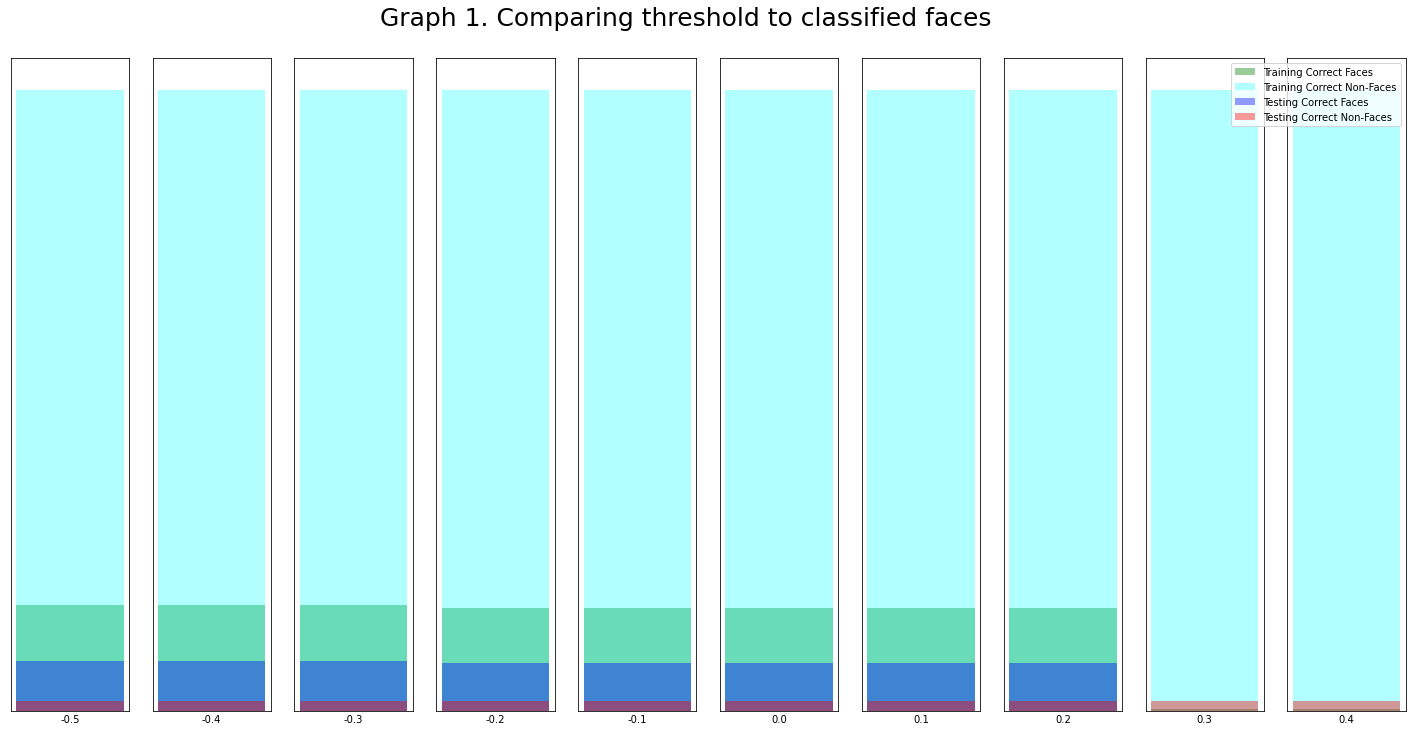

In [158]:
thresholds = np.array([x for x in range(-5,5,1)])/10
fig, axs = plt.subplots(1, 10,figsize=(25,12))
plt.suptitle("Graph 1. Comparing threshold to classified faces",y=0.94,size=25)
axs = axs.ravel()
#ax = plt.subplot(111)
for idx, x in enumerate(thresholds):
  train_correct_faces = sum(ensemble_vote_all_t(pos_train_imgs, classifiers, x))
  train_correct_non_faces = len(neg_train_imgs) - sum(ensemble_vote_all_t(neg_train_imgs, classifiers, x))

  test_correct_faces = sum(ensemble_vote_all_t(pos_test_imgs, classifiers, x))
  test_correct_non_faces = len(neg_test_imgs) - sum(ensemble_vote_all_t(neg_test_imgs, classifiers, x))
  
  axs[idx].bar(x,train_correct_faces, width=0.2, color='g', align='center',label='Training Correct Faces',alpha=0.4)
  axs[idx].bar(x,train_correct_non_faces, width=0.2, color='cyan', align='center',label='Training Correct Non-Faces',alpha=0.3)
  axs[idx].bar(x,test_correct_faces, width=0.2, color='b', align='center',label='Testing Correct Faces',alpha=0.4)
  axs[idx].bar(x,test_correct_non_faces, width=0.2, color='r', align='center',label='Testing Correct Non-Faces',alpha=0.4)
  #axs[idx].set_title(f"Threshold: {x}")
  axs[idx].set_xlabel(x)
  axs[idx].set_xticks([])
  axs[idx].set_yticks([])

  #axs[idx].axis("off")
plt.legend()
plt.show()

*   Discuss what happens when you increase the threshold value.

**Solution**

The following happens: 
- Training correct non-faces = constant 
- training correct faces = constant up until 0.3+
- testing faces & non-faces constant until 0.3+

We can see a sort of "convergence" with the performance results since we can see that up until 0.3 as a threshold value, causes the other things to go down. 

This would mean that we'd need to find a way to check which threshold would be the best suited for the problem. In the end, threshold affects the way the final results are scored or "voted" on. We can see that in the values of 0.3 upwards The classified results decrease a lot. However, what we find interesting is that the training correct non-faces is not affected by the threshold. Which could be because we'd need to run the "learn" function using this threshold function for it to iterate over all of the values. Then one could make a much better comparisson. In such a way that, when running the "learn" function, within we can modify it and add another loop which would iterate over the threshold and then return a dictionary of results, then one would be able to have a more in-depth comparisson. 

# Face Recognition using PCA


In [45]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

from time import time
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

*   Loading the dataset

In [46]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


*   Creating training and testing set

In [47]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print('Train data shape:', X_train.shape)
print('Test data shape:', X_test.shape)
print('Number of classes in Train set:', np.unique(y_train).shape[0])

Train data shape: (966, 1850)
Test data shape: (322, 1850)
Number of classes in Train set: 7


### Exercise #1: PCA Computation
*   Compute a PCA (eigenfaces) on the face dataset
    *   *Set* number of components to 100

In [48]:
# solution
components = 100 
#debug statment 
print(f"Extracting {components} eigenfaces from {X_train.shape[0]} features")
# instantiating the PCA
pca = PCA(n_components = components).fit(X_train)


Extracting 100 eigenfaces from 966 features


*   Reshape the components output of pca to obtain the eigen faces

In [49]:
# solution
targ_shape = (components, h,w)
eigenface = pca.components_.reshape(targ_shape)

*   Project the training and testing faces data on the orthonormal basis

In [50]:
# solution
#training data 
X_train_proc = pca.transform(X_train)
#testing data 
X_test_proc = pca.transform(X_test)

*   Plot the most significative eigenfaces (Show the top 12 eigenfaces) as a matplotlib

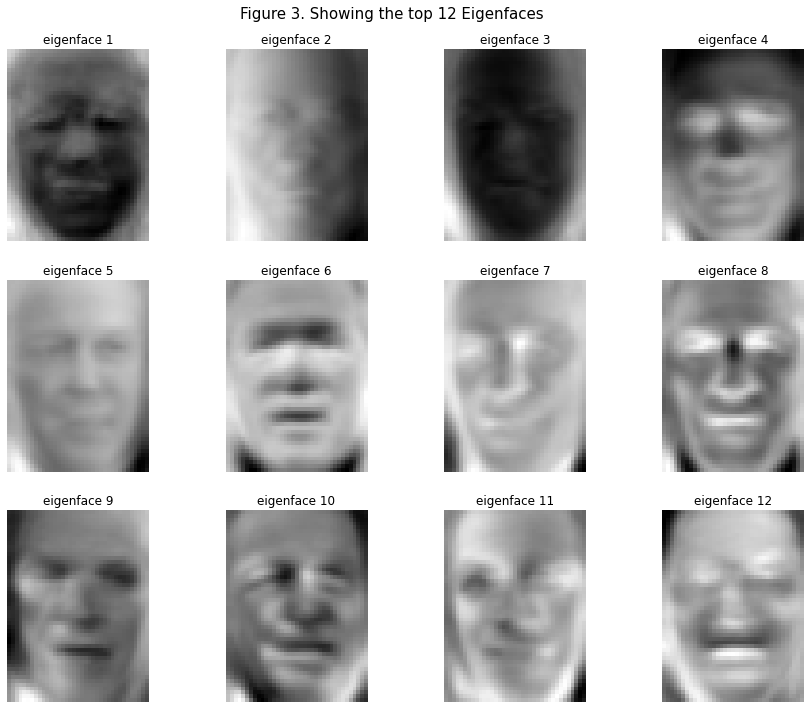

In [51]:
def plot_eigenfaces(images, titles, h, w, FIGSIZE=None):
    fig, axs = plt.subplots(3, 4,figsize=FIGSIZE)
    plt.suptitle('Figure 3. Showing the top 12 Eigenfaces',y=0.93, size=15)
    axs=axs.ravel()
    for x in range(3*4):
        axs[x].imshow(images[x].reshape((h,w)), cmap=plt.cm.gray)
        axs[x].set_title(titles[x])
        axs[x].axis('off')
    plt.show()
    
    
eigenface_titles = [f"eigenface {i+1}" for i in range(eigenface.shape[0])]
plot_eigenfaces(eigenface, eigenface_titles, h, w, FIGSIZE=(15,12))
plt.show()

*   Show the total percentage of variance explained by the selected components of the PCA.


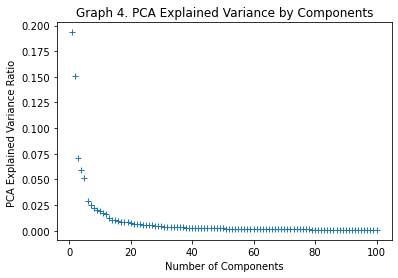

In [52]:
# solution
X = np.arange(1, pca.n_components_ + 1)
Y = pca.explained_variance_ratio_
plt.plot(X, Y,'+')
plt.title("Graph 4. PCA Explained Variance by Components")
plt.ylabel('PCA Explained Variance Ratio ')
plt.xlabel('Number of Components')
plt.show()

*   What are the shortcomings of PCA?

**Solution**

There are several shortcomings of PCA. Principally, the data that is returned from a PCA is not entirely readable as the original features because it creates a larger embedding. The data ought to be standardized before performing PCA because the algorithm won't be able to find the ideal number of components afterwards. There is no correlation between the components after applying PCA, since they now become independent of each other. Lastly, there is a large loss of information when performing PCA, if the number of components is not chosen adequately, since some of the components can be removed and we "lose" them in the preprocessing part before the modeling. 

### Exercise #2: k-NN Classification

*   Train a k-nearest neighbor model with the eigenfaces using the default parameters

In [8]:
# solution
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

KNeighborsClassifier()

*   Predict the test data using the trained classifier

In [12]:
# Quantitative evaluation of the model quality on the test set
# prediction on the test set 
preds = knn.predict(X_test)
#getting the score for X_test and y_test
score = knn.score(X_test, y_test)

### Exercise #3: Quantitative results

*   Compute accuracy, classification report and confusion matrix of the trained classifier

In [24]:
# solution
#separating the evaluator from the classifier as per design 
acc = accuracy_score(y_test,preds)
acc = acc * 100
assert score*100 == acc
print(f"The accuracy for the k-NN model is {acc:.2f}%")

The accuracy for the k-NN model is 59.63%


In [26]:
# solution
#classification report 
cr = classification_report(y_test, preds)
print(cr)

              precision    recall  f1-score   support

           0       0.27      0.31      0.29        13
           1       0.57      0.62      0.59        60
           2       0.42      0.41      0.42        27
           3       0.66      0.82      0.73       146
           4       0.44      0.16      0.24        25
           5       0.56      0.33      0.42        15
           6       0.67      0.33      0.44        36

    accuracy                           0.60       322
   macro avg       0.51      0.42      0.45       322
weighted avg       0.59      0.60      0.58       322



In [28]:
# solution
#confusion matrix 
cm = confusion_matrix(y_test, preds)
cm

array([[  4,   2,   1,   6,   0,   0,   0],
       [  3,  37,   3,  14,   1,   1,   1],
       [  4,   4,  11,   8,   0,   0,   0],
       [  4,   8,   6, 119,   4,   3,   2],
       [  0,   4,   4,  10,   4,   0,   3],
       [  0,   3,   0,   7,   0,   5,   0],
       [  0,   7,   1,  16,   0,   0,  12]])

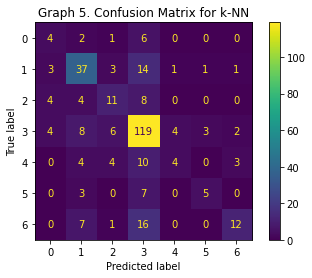

In [57]:
# nicer way of visualizing it 
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = knn.classes_)
disp.plot()
plt.title("Graph 5. Confusion Matrix for k-NN")
plt.show()

*   Explain the measures showed in the classification report.
*   Discuss the obtained classification results, both the quantitative as well as the qualitative results.

**Solution**

*Classification Report*

*Measures*

In the classification report we have 4 main metrics which are: 
- Precision 
- Recall 
- F1-score 
- Support 

For precision, by definition it is the ability of the classifier not to label as positive a sample that is actually negative. 
Recall, on the other hand, is the ability for the classifier to find all positive samples. 
Then the F1-score, can be considered as a weighted harmonic mean of precision and recall (sklearn definition). The best value for the F1-score is the closer it is to 1 and worse when it is closer to 0. 

*Explanation* 

What does the classification report show in this scenario? We see that a vanilla knn's precision score on average is between 0.51 and 0.59 (macro avg and weighted avg). This tells us that the classification power of the knn is almost similar to a coin-toss. The recall shows that its ability to actually identify positive samples is low (0.42-0.60). 

Since the qualitative results will be shown below, more detail will be written alognside the corresponding questions. However, we can already tell that we'd need to find the optimal number for k which is done via an elbow plot. This will show at which k, k-NN performs the best. 
Moreover, we saw with the n_components of PCA, that the explained_variance_ratio decreases as we increase the number of components. 


### Exercise #4

*   How is the optimal value of 'k' found?

**Solution**

The optimal value of k can be found using an elbow plot. This means that we try different values for k (in a loop) and then plot the results for each. When this is plotted, we can see a "kink" (similar to an elbow, hence the name), which is at an obtuse angle, indicating a shift in the accuracy of the model. However, a standard for finding out the ideal k, to start with is $k=N^{1/2}$.

*   Use GridSearch to find the optimal value of 'k'.
    *   *Hint: GridSearchCV is available in sklearn.model_selection*
*   What is the accuracy of the best estimator?

In [41]:
# solution
k_ranges = list(range(1, 31))
param_grid = dict(n_neighbors=k_ranges)

#defining the grid 
grid = GridSearchCV(knn, param_grid,
                    cv=10,
                    scoring='accuracy',
                    return_train_score=False,
                    verbose=1,
                    n_jobs=-1)

#searching 
grid_search = grid.fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   54.0s finished


In [58]:
#showing the best k 
best_k = grid_search.best_params_
print(f"The best score was done with k = {best_k['n_neighbors']}")
# showing the accuracy with the best k 
best_score = grid_search.best_score_ * 100
print(f"Accuracy with {best_k['n_neighbors']} is {best_score:.2f}%")

The best score was done with k = 8
Accuracy with 8 is 56.53%


### Exercise #5: Qualitative evaluation

*   Plot some of the prediction images using matplotlib subplots (4 x 4). Show the true label and predicted label as the title of each sub plot.

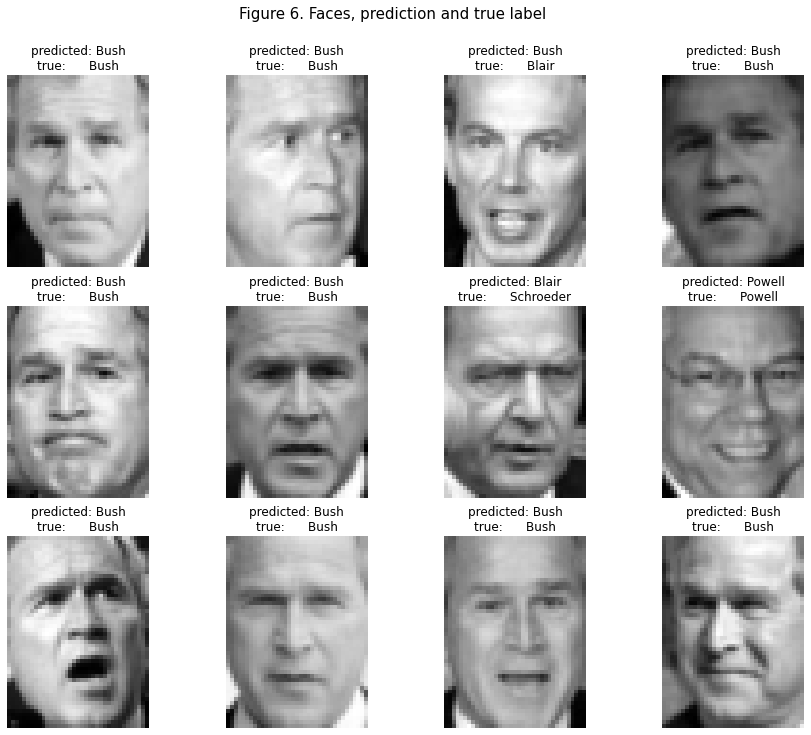

In [61]:
# https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
# modified the helper functions to make it easier to plot 

def plot_eigenfaces_pred(images, titles, h, w, FIGSIZE=None):
    fig, axs = plt.subplots(3, 4,figsize=FIGSIZE)
    plt.suptitle('Figure 6. Faces, prediction and true label',y=0.96, size=15)
    axs=axs.ravel()
    for x in range(3*4):
        axs[x].imshow(images[x].reshape((h,w)), cmap=plt.cm.gray)
        axs[x].set_title(titles[x])
        axs[x].axis('off')
    plt.show()

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)

prediction_titles = [
    title(preds, y_test, target_names, i) for i in range(preds.shape[0])
]

plot_eigenfaces_pred(X_test, prediction_titles, h, w,FIGSIZE=(15,12))

*   What are the disadvantages of using kNN

**Solution**

Disadvantages: 
- Quality of the data is important
- Processing power is high when the dataset is large 
- Requires high memoray usage 
- Everytime a prediction is needed, it scans the entire database again (in this case the dataset).
- very sensitive to outliers, since it tries to "cluster" into a specific group. 


---

# **End of P3: Face Detection and Recognition**
Deadline for P3 submission in CampusVirtual is: **Monday, the 22nd of November, 2021**